## Region Proposal Network

**Program Flow**

1) Preprocess data to fit the format of Faster R-CNN.
   - Extract information from the image and label files of Pascal VOC.
   - Generate anchors based on a fixed kernel size.
   - Keep track of list of anchors that should be ignored (out of boundary anchors).
   - Determine positive and negative anchors for each image data (based on the ground-truth boxes).
   - Determine the difference between positive anchors and the corresponding ground-truth objects based on the given formula (how much the anchor needs be adjusted to fit the ground-truth box).
   - Sample a fixed amount of anchors for training (by using the list to keep track of ignored anchors earlier).

2) Build RPN model.
    - Make sure the kernel size selected is the same with the kernel size used when generating anchors earlier.
    - Make sure the ignored anchors do not contribute to loss.
    
3) Post-Processing.
    - Choose prediction anchors that are above a certain confidence level to represent the bounding boxes.
    - Use the correct anchors (generated ones) to apply the regression results to. 
    - Use Non-Max Suppression technique to filter out overlapping bounding boxes.
    
**NOTE** : The pre-trained model (VGG-16) for classification was trained on aeroplane vs bicycle dataset. This RPN is trained to detect only aeroplanes. (Filtered out in block 12, line 25)

In [1]:
#Imports
import numpy as np
import os
import glob
import cv2
import xmltodict
import tensorflow as tf
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

/home/topiary/nasa/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/topiary/nasa/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/topiary/nasa/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/topiary/nasa/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:522: Futu

In [2]:
data_images_path     = '../../VOCdevkit/VOC2012/JPEGImages'
data_annotation_path = '../../VOCdevkit/VOC2012/Annotations'
trained_model_path = './trained_model/'
image_height = 224
image_width  = 224
image_depth  = 3
rpn_kernel_size = 3
subsampled_ratio = 8
anchor_sizes = [32,64,128]
anchor_aspect_ratio = [[1,1],[1,2],[2,1]]
num_anchors_in_box = len(anchor_sizes)*len(anchor_aspect_ratio)
neg_threshold = 0.1
pos_threshold = 0.5
anchor_sampling_amount = 64

In [3]:
#Get the image and annotation file paths
list_images      = sorted([x for x in glob.glob(data_images_path + '/**')])     #length : 17125
list_annotations = sorted([x for x in glob.glob(data_annotation_path + '/**')]) #length : 17125
total_images = len(list_images)

### DATA PREPROCESSING

In [4]:
def get_classes(xml_files=list_annotations):
    '''
    Output: All the distinct classes for this dataset.
    
    '''
    classes = []
    
    for file in xml_files: 

        f = open(file)
        doc = xmltodict.parse(f.read()) #parse the xml file to python dict.

        #Images in the dataset might contain either 1 object or more than 1 object. For images with 1 object, the annotation for the object
        #in the xml file will be located in 'annotation' -> 'object' -> 'name'. For images with more than 1 object, the annotations for the objects
        #will be nested in 'annotation' -> 'object' thus requiring a loop to iterate through them. (Pascal VOC format)

        try: 
            #try iterating through the tag. (For images with more than 1 obj.)
            for obj in doc['annotation']['object']:
                classes.append(obj['name'].lower()) #append the lowercased string.

        except TypeError as e: #iterating through non-nested tags would throw a TypeError.
            classes.append(doc['annotation']['object']['name'].lower()) #append the lowercased string.

        f.close()

    classes = list(set(classes)) #remove duplicates.
    classes.sort()

    #returns a list containing the names of classes after being sorted.
    return classes

In [5]:
classes = get_classes()
num_of_class = len(classes)
excluded_classes = classes[2:] #Classes to be excluded during training

In [6]:
def get_labels_from_xml(xml_file_path, num_of_class = num_of_class):
    '''
    Input : A SINGLE xml file and the total number of classes in the dataset. 
    Output: Labels in numpy array format (Object classes their corresponding bounding box coordinates).

    Desc : This function parses a single xml file and outputs the objects classes and their corresponding bounding box coordinates
           [top-left-x, top-left-y, btm-right-x, btm-right-y] on the resized image.

    '''

    f = open(xml_file_path)
    doc = xmltodict.parse(f.read()) #parse the xml file to python dict.

    #get the original image height and width. Images have different height and width from each other.
    ori_img_height = float(doc['annotation']['size']['height'])
    ori_img_width  = float(doc['annotation']['size']['width'])


    class_label = [] #init for keeping track objects' labels.
    bbox_label  = [] #init for keeping track of objects' bounding box (bb).


    #Images in the dataset might contain either 1 object or more than 1 object. For images with 1 object, the annotation for the object
    #in the xml file will be located in 'annotation' -> 'object' -> 'name'. For images with more than 1 object, the annotations for the objects
    #will be nested in 'annotation' -> 'object' thus requiring a loop to iterate through them. (Pascal VOC format)
    try:
        #Try iterating through the tag (For images with more than 1 obj).
        for each_obj in doc['annotation']['object']:
            
            obj_class = each_obj['name'].lower() #get the label for the object and lowercase the string.
            
            if obj_class in excluded_classes:
                continue

            #Pascal VOC's format to denote bounding boxes are to denote the top left part of the box and the bottom right of the box.
            #the coordinates are in terms of x and y axis for both part of the box.
            x_min = float(each_obj['bndbox']['xmin']) #top left x-axis coordinate.
            x_max = float(each_obj['bndbox']['xmax']) #bottom right x-axis coordinate.
            y_min = float(each_obj['bndbox']['ymin']) #top left y-axis coordinate.
            y_max = float(each_obj['bndbox']['ymax']) #bottom right y-axis coordinate.

        ##################################################################################
        #We want to make sure the coordinates are resized according to the resized image.#
        ##################################################################################

            #All the images will be resized to a fixed size in order to be fixed-size inputs to the neural network model.
            #Therefore, we need to resize the coordinates as well since the coordinates above is based on the original size of the images.

            #In order to find the resized coordinates, we must multiply the ratio of the resized image compared to its original to the coordinates.
            x_min = float((image_width/ori_img_width)*x_min)
            y_min = float((image_height/ori_img_height)*y_min)
            x_max = float((image_width/ori_img_width)*x_max)
            y_max = float((image_height/ori_img_height)*y_max)

            generated_box_info = [x_min, y_min, x_max, y_max]


            index = classes.index(obj_class) #get the index of the object's class.

            #append each object's class label and the bounding box label (converted to Faster R-CNN format) into the list initialized earlier.
            class_label.append(index)
            bbox_label.append(np.asarray(generated_box_info, dtype='float32'))

    except TypeError as e : #happens when the iteration through the tag fails due to only 1 object being in the image.

        #SAME PROCEDURE AS ABOVE !  

        #Getting these information from the XML file differs compared to above,
        obj_class = doc['annotation']['object']['name']
        
        if not obj_class in excluded_classes:
                        
            x_min = float(doc['annotation']['object']['bndbox']['xmin']) 
            x_max = float(doc['annotation']['object']['bndbox']['xmax']) 
            y_min = float(doc['annotation']['object']['bndbox']['ymin']) 
            y_max = float(doc['annotation']['object']['bndbox']['ymax']) 

            x_min = float((image_width/ori_img_width)*x_min)
            y_min = float((image_height/ori_img_height)*y_min)
            x_max = float((image_width/ori_img_width)*x_max)
            y_max = float((image_height/ori_img_height)*y_max)

            generated_box_info = [x_min, y_min, x_max, y_max]

            #Get the index of the class
            index = classes.index(obj_class) 

            class_label.append(index)
            bbox_label.append(np.asarray(generated_box_info, dtype='float32'))


    return class_label, np.asarray(bbox_label)

In [7]:
def generate_anchors(rpn_kernel_size=rpn_kernel_size, subsampled_ratio=subsampled_ratio,
                     anchor_sizes=anchor_sizes, anchor_aspect_ratio=anchor_aspect_ratio):

    '''
    Since Faster R-CNN works by placing different sized anchors throughout an image on different positions, we need to generate the coordinates
    for each of those anchors first before generating the labels required by Faster R-CNN. This function generates the anchors based on number
    of anchors, sizes of anchors, aspect ratios of anchors, RPN's kernel size and subsampled size of the image.

    Output : list of anchors (each anchor is denoted by (x,y,w,h)) and the list if an anchor should be ignored or not.

    '''

    list_of_anchors = []
    anchor_booleans = [] #This is to keep track of an anchor's status. Anchors that are out of boundary are meant to be ignored.

    #get the feature map's height and width after convolutions and poolings.


    #the anchor's center is always at the middle grid of the RPN kernel. Therefore, we need to imitate the kernel slide to get all the
    #centers of the anchor. If a kernel is 3x3, the center will start from (1,1). If a kernel is 5x5, the center will start from (2,2).
    #we use divmod to get the first coordinate of the RPN kernel's middle point.
    starting_center = divmod(rpn_kernel_size, 2)[0]

    anchor_center = [starting_center - 1,starting_center] #-1 on the x-coor because the increment comes first in the while loop below.

    #We want to imitate the kernel sliding with stride 1 until it reaches the ending center. Since index starts with 0, we subtract 1 more to the 
    #width and height of the subsampled image.
    subsampled_height = image_height/subsampled_ratio
    subsampled_width = image_width/subsampled_ratio
    
    while (anchor_center != [subsampled_width - (1 + starting_center), subsampled_height - (1 + starting_center)]): 


        anchor_center[0] += 1 #Increment the x-axis by 1.

        #If the sliding window has reached the last central point at the right side, increase the y-axis by 1 and 
        #reset x-axis to 0.
        if anchor_center[0] > subsampled_width - (1 + starting_center):

            anchor_center[1] += 1
            anchor_center[0] = starting_center

        #Even though we calculate the anchor on the feature map, the anchors are still referenced to the original image. Therefore, 
        #once we obtain the position of the center of the anchor on the feature map, we multiply is by the downsampling ratio to obtain its 
        #center position referenced to the original input image.
        anchor_center_on_image = [anchor_center[0]*subsampled_ratio, anchor_center[1]*subsampled_ratio]

        #We want to calculate the anchor's height and width on all the different variations of aspect ratio and sizes.
        #Iterate through every size defined for each anchor center's position.
        for size in anchor_sizes:

            #Iterate through every aspect ratio for each size.
            for a_ratio in anchor_aspect_ratio:

                #[x,y,w,h] of an anchor.
                anchor_info = [anchor_center_on_image[0], anchor_center_on_image[1], size*a_ratio[0], size*a_ratio[1]]

                #Perform check if a given anchor crosses the boundary of the image or not. Such anchors are to be ignored and will be labelled as 0.
                #Else the anchor will be labelled as 1 (meaning good to go).
                if (anchor_info[0] - anchor_info[2]/2 < 0 or anchor_info[0] + anchor_info[2]/2 > image_width or 
                                        anchor_info[1] - anchor_info[3]/2 < 0 or anchor_info[1] + anchor_info[3]/2 > image_height) :

                    anchor_booleans.append([0.0])

                else:

                    anchor_booleans.append([1.0])

                list_of_anchors.append(anchor_info)

    return list_of_anchors, anchor_booleans

In [8]:
def IoU_calculator(box1, box2, area1=None, area2=None):
    '''
    Inputs two boxes (each with top-left-x, top-left-y, btm-right-x, btm-right-y coordinates).
    If the area of one or two of the boxes are known, it can be passed here as well.
    Calculates the IoU between the two boxes and returns the IoU.
    '''
    
    #Get the area of the boxes
    if area1 is None:
        #Area of the box1. +1 since index starts from 0.
        area1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    
    if area2 is None:
        #Area of the box 2. +1 since index starts from 0.
        area2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    
    #Determine the intersection rectangle.
    int_rect_top_left_x = max(box1[0], box2[0])
    int_rect_top_left_y = max(box1[1], box2[1])
    int_rect_btm_rght_x = min(box1[2], box2[2])
    int_rect_btm_rght_y = min(box1[3], box2[3])
    
    #if the boxes do not intersect, the difference will be < 0. Hence we pick 0 in those cases.
    int_rect_area = max(0, int_rect_btm_rght_x - int_rect_top_left_x + 1)*max(0, int_rect_btm_rght_y - int_rect_top_left_y)
    
    #Calculate the IoU.
    try:
        intersect_over_union = float(int_rect_area / (area1 + area2 - int_rect_area))
    except ZeroDivisionError:
        
        intersect_over_union = 0
        
    
    return intersect_over_union
    

In [9]:
'''
This function was previously used to segregate positive and negative anchors based on selected IoU thresholds.

'''
# def generate_label(class_labels, ground_truth_boxes, anchors, anchor_booleans, num_class=num_of_class,
#                     neg_anchor_thresh = neg_threshold, pos_anchor_thresh = pos_threshold):
#     '''
#     Each and every anchor that was generated (except for the ignored ones) must be labelled with either positive or negative depending on how
#     much the particular anchor box intersects with a ground-truth box. If an anchor is positive, the difference between the anchor's [x,y,w,h] and the
#     ground-truth box's [x,y,w,h] must be calculated in order for the network to learn how much to regress later on.

#     Input  : Classes, Ground truth box(es) belonging to one image [top-left-x, top-left-y, btm-right-x, btm-right-y], all the anchors and anchor booleans.
#     Output : Anchor Booleans (to know which anchor to ignore), Objectness array, Coordinate difference array.
#     '''


#     number_of_anchors = len(anchors) #Get the total number of anchors.

#     #For every anchor, we want a 1-D array that denotes whether the anchor should contribute to the loss or not. By default, all of them contributes.
#     #Since we already have the anchor booleans list, we will convert that into a numpy array and reshape it accordingly.
#     anchor_boolean_array   = np.reshape(np.asarray(anchor_booleans),(number_of_anchors, 1))
#     #For every anchor, we want a 2-D array that denotes whether the IoU of the anchor with a ground-truth object is more than certain threshold or not.
#     objectness_label_array = np.zeros((number_of_anchors, 2), dtype=np.float32)
#     #For every anchor, we want a 4-D array that denotes how much the anchor should regress in order to fit an object. (Only for positive anchors)
#     box_regression_array   = np.zeros((number_of_anchors, 4), dtype=np.float32)
#     #For every anchor, we want a num_of_class-D array that denotes which class does the object belongs to (Only if the anchor is positive)
#     class_array            = np.zeros((number_of_anchors, num_class), dtype=np.float32)

#     #We want to iterate through every ground truth box.
#     for j in range(ground_truth_boxes.shape[0]):

#         #get the class label
#         class_label = class_labels[j]

#         #Get the ground truth box's coordinates.
#         gt_box_top_left_x = ground_truth_boxes[j][0]
#         gt_box_top_left_y = ground_truth_boxes[j][1]
#         gt_box_btm_rght_x = ground_truth_boxes[j][2]
#         gt_box_btm_rght_y = ground_truth_boxes[j][3]

#         #Calculate the area of the original bounding box.1 is added since the index starts from 0 not 1.
#         gt_box_area = (gt_box_btm_rght_x - gt_box_top_left_x + 1)*(gt_box_btm_rght_y - gt_box_top_left_y + 1)

#         #Loop through the anchors.
#         for i in range(number_of_anchors):

#             #Check if the anchor should be ignored or not. If it is to be ignored, skip this i-th loop.
#             if int(anchor_boolean_array[i][0]) == 0:
#                 continue

#             anchor = anchors[i] #Select the i-th anchor [x,y,w,h]

#             #Since our anchors are in [x,y,w,h] format, we want to convert them to the [top-left-x, top-left-y, btm-right-x, btm-right-y] first.
#             anchor_top_left_x = anchor[0] - anchor[2]/2
#             anchor_top_left_y = anchor[1] - anchor[3]/2
#             anchor_btm_rght_x = anchor[0] + anchor[2]/2
#             anchor_btm_rght_y = anchor[1] + anchor[3]/2

#             #Get the area of the bounding box.
#             anchor_box_area = (anchor_btm_rght_x - anchor_top_left_x + 1)*\
#                                     (anchor_btm_rght_y - anchor_top_left_y + 1)

#             #wrap up both the ground truth box and the anchor box in lists.
#             box_1 = [gt_box_top_left_x, gt_box_top_left_y, gt_box_btm_rght_x, gt_box_btm_rght_y]
#             box_2 = [anchor_top_left_x, anchor_top_left_y, anchor_btm_rght_x, anchor_btm_rght_y]
            
#             #Get the IoU.
#             intersect_over_union = IoU_calculator(box_1, box_2, gt_box_area, anchor_box_area)
            
            
#             #If the IoU is above or equal to the set threshold, then we want to label it as a positive anchor.
#             #If it is lower or equal to the set threshold, we want to label it as a negative anchor.
#             #Normally, there are going to be more negative anchors than the positive ones.
#             #In an image, there might be more than 1 object. Therefore, an anchor which was labelled as positive for the first object
#             #can be labelled as negative for the second object. We do not want the positive anchors to be overwritten since positive anchors
#             #are naturally lower in number. Therefore, if an anchor is already labelled positively, we're not going to label it as negative nor neutral
#             #on the following objects.
#             if intersect_over_union >= pos_anchor_thresh:


#                 objectness_label_array[i][0] = 1.0 #positive label is on the left
#                 objectness_label_array[i][1] = 0.0 #overwrite the negative label in case this anchor is labelled negatively for previous object(s).

#                 class_array[i][int(class_label)] = 1.0 #Denote the label of the class in the array.

#                 ##################################################################
#                 #We want to calculate the regression values for positive anchors.#
#                 ##################################################################

#                 #Get the ground-truth box's [x,y,w,h]
#                 gt_box_center_x = ground_truth_boxes[j][0] + (ground_truth_boxes[j][2] - ground_truth_boxes[j][0])/2
#                 gt_box_center_y = ground_truth_boxes[j][1] + (ground_truth_boxes[j][3] - ground_truth_boxes[j][1])/2
#                 gt_box_width    = ground_truth_boxes[j][2] - ground_truth_boxes[j][0]
#                 gt_box_height   = ground_truth_boxes[j][3] - ground_truth_boxes[j][1]

#                 #Regression loss according to the paper.
#                 delta_x = (gt_box_center_x - anchor[0])/anchor[2]
#                 delta_y = (gt_box_center_y - anchor[1])/anchor[3]
#                 delta_w = math.log(gt_box_width/anchor[2])
#                 delta_h = math.log(gt_box_height/anchor[3])

#                 #Fill in the calculated values in the array.
#                 box_regression_array[i][0] = delta_x
#                 box_regression_array[i][1] = delta_y
#                 box_regression_array[i][2] = delta_w
#                 box_regression_array[i][3] = delta_h

#             if intersect_over_union <= neg_anchor_thresh:

#                 #Check if the anchor is already labelled positive or not.
#                 if int(objectness_label_array[i][0]) == 0:

#                     objectness_label_array[i][1] = 1.0

#             #These are neutral anchors.
#             if intersect_over_union > neg_anchor_thresh and intersect_over_union < pos_anchor_thresh:

#                 #We do not want to label either the negative or the positive anchors as neutral.
#                 if int(objectness_label_array[i][0]) == 0 and int(objectness_label_array[i][1]) == 0:
#                     anchor_boolean_array[i][0] = 0.0 #Neutral anchors are to be ignored.


#     return anchor_boolean_array, objectness_label_array, box_regression_array, class_array

In [10]:
def generate_label(class_labels, ground_truth_boxes, anchors, anchor_booleans, num_class=num_of_class,
                    neg_anchor_thresh = neg_threshold, pos_anchor_thresh = pos_threshold):
    '''
    Each and every anchor that was generated (except for the ignored ones) must be labelled with either positive or negative depending on how
    much the particular anchor box intersects with a ground-truth box. If an anchor is positive, the difference between the anchor's [x,y,w,h] and the
    ground-truth box's [x,y,w,h] must be calculated in order for the network to learn how much to regress later on. We pick the first n number of anchors with 
    lowest IoUs as negative anchors and the first n number of anchors with the highest IoUs as positive anchors.

    Input  : Classes, Ground truth box(es) belonging to one image [top-left-x, top-left-y, btm-right-x, btm-right-y], all the anchors and anchor booleans.
    Output : Anchor Booleans (to know which anchor to ignore), Objectness array, Coordinate difference array.
    '''


    number_of_anchors = len(anchors) #Get the total number of anchors.

    #For every anchor, we want a 1-D array that denotes whether the anchor should contribute to the loss or not. By default, all of them contributes.
    #Since we already have the anchor booleans list, we will convert that into a numpy array and reshape it accordingly.
    anchor_boolean_array   = np.reshape(np.asarray(anchor_booleans),(number_of_anchors, 1))
    #For every anchor, we want a 2-D array that denotes whether the IoU of the anchor with a ground-truth object is more than certain threshold or not.
    objectness_label_array = np.zeros((number_of_anchors, 2), dtype=np.float32)
    #For every anchor, we want a 4-D array that denotes how much the anchor should regress in order to fit an object. (Only for positive anchors)
    box_regression_array   = np.zeros((number_of_anchors, 4), dtype=np.float32)
    #For every anchor, we want a num_of_class-D array that denotes which class does the object belongs to (Only if the anchor is positive)
    class_array            = np.zeros((number_of_anchors, num_class), dtype=np.float32)

    #We want to iterate through every ground truth box.
    for j in range(ground_truth_boxes.shape[0]):

        #get the class label
        class_label = class_labels[j]

        #Get the ground truth box's coordinates.
        gt_box_top_left_x = ground_truth_boxes[j][0]
        gt_box_top_left_y = ground_truth_boxes[j][1]
        gt_box_btm_rght_x = ground_truth_boxes[j][2]
        gt_box_btm_rght_y = ground_truth_boxes[j][3]

        #Calculate the area of the original bounding box.1 is added since the index starts from 0 not 1.
        gt_box_area = (gt_box_btm_rght_x - gt_box_top_left_x + 1)*(gt_box_btm_rght_y - gt_box_top_left_y + 1)
        
        anchors_iou = np.zeros(number_of_anchors, dtype=np.float32)
        
        #Loop through the anchors.
        for i in range(number_of_anchors):

            #Check if the anchor should be ignored or not. If it is to be ignored, skip this i-th loop.
            if int(anchor_boolean_array[i][0]) == 0:
                continue

            anchor = anchors[i] #Select the i-th anchor [x,y,w,h]

            #Since our anchors are in [x,y,w,h] format, we want to convert them to the [top-left-x, top-left-y, btm-right-x, btm-right-y] first.
            anchor_top_left_x = anchor[0] - anchor[2]/2
            anchor_top_left_y = anchor[1] - anchor[3]/2
            anchor_btm_rght_x = anchor[0] + anchor[2]/2
            anchor_btm_rght_y = anchor[1] + anchor[3]/2

            #Get the area of the bounding box.
            anchor_box_area = (anchor_btm_rght_x - anchor_top_left_x + 1)*\
                                    (anchor_btm_rght_y - anchor_top_left_y + 1)

            #wrap up both the ground truth box and the anchor box in lists.
            box_1 = [gt_box_top_left_x, gt_box_top_left_y, gt_box_btm_rght_x, gt_box_btm_rght_y]
            box_2 = [anchor_top_left_x, anchor_top_left_y, anchor_btm_rght_x, anchor_btm_rght_y]
            
            #Get the IoU.
            intersect_over_union = IoU_calculator(box_1, box_2, gt_box_area, anchor_box_area)
            
            anchors_iou[i] = intersect_over_union
        
        ascending_iou_index = anchors_iou.argsort(axis=0) #sort the iou array in ascending order.
        
        negative_anchors_index = ascending_iou_index[:anchor_sampling_amount] #first n anchors 
        positive_anchors_index = ascending_iou_index[-1*anchor_sampling_amount:] #last n anchors
        
        for i in negative_anchors_index:
            
            #if already positive anchor
            if int(objectness_label_array[i][0]) == 1:
                continue
            objectness_label_array[i][1] = 1.0
        
        for i in positive_anchors_index:
            
            anchor = anchors[i] #Select the i-th anchor [x,y,w,h]
            
            objectness_label_array[i][0] = 1.0 #positive label is on the left
            objectness_label_array[i][1] = 0.0 #overwrite the negative label in case this anchor is labelled negatively for previous object(s).
            
            class_array[i][int(class_label)] = 1.0 #Denote the label of the class in the array.

            ##################################################################
            #We want to calculate the regression values for positive anchors.#
            ##################################################################

            #Get the ground-truth box's [x,y,w,h]
            gt_box_center_x = ground_truth_boxes[j][0] + (ground_truth_boxes[j][2] - ground_truth_boxes[j][0])/2
            gt_box_center_y = ground_truth_boxes[j][1] + (ground_truth_boxes[j][3] - ground_truth_boxes[j][1])/2
            gt_box_width    = ground_truth_boxes[j][2] - ground_truth_boxes[j][0]
            gt_box_height   = ground_truth_boxes[j][3] - ground_truth_boxes[j][1]

            #Regression loss according to the paper.
            delta_x = (gt_box_center_x - anchor[0])/anchor[2]
            delta_y = (gt_box_center_y - anchor[1])/anchor[3]
            delta_w = math.log(gt_box_width/anchor[2])
            delta_h = math.log(gt_box_height/anchor[3])

            #Fill in the calculated values in the array.
            box_regression_array[i][0] = delta_x
            box_regression_array[i][1] = delta_y
            box_regression_array[i][2] = delta_w
            box_regression_array[i][3] = delta_h   
    
    #regression array for anchors with objects only.
    box_regression_array = np.reshape(objectness_label_array[:,0], (-1,1)) * box_regression_array
    
    return anchor_boolean_array, objectness_label_array, box_regression_array, class_array

In [11]:
def anchor_sampling(anchor_booleans, objectness_label, anchor_sampling_amount=anchor_sampling_amount):

    '''
    Faster R-CNN randomly samples a fixed amount of negative anchors and positive anchors for training. If we use all the neg and pos anchors,
    our model will overfit on the negative ones as negative anchors are larger in amount compared to the positive anchors.

    Input : anchor booleans and objectness label
    Output: Updated anchor booleans. 

    '''

    positive_count = 0
    negative_count = 0
    

    #Iterate through every label.
    for i in range(objectness_label.shape[0]):

        if int(objectness_label[i][0]) == 1: #If the anchor is positively labelled.

            if positive_count > anchor_sampling_amount: #If the positive anchors are more than the threshold amount, set the boolean to 0.

                anchor_booleans[i][0] = 0.0

            positive_count += 1

        if int(objectness_label[i][1]) == 1: #If the anchor is negatively labelled.

            if negative_count > anchor_sampling_amount: #If the negative anchors are more than the threshold amount, set the boolean to 0.

                anchor_booleans[i][0] = 0.0

            negative_count += 1

    #Return the updated booleans. REMEMBER! This array was passed by reference. 
    return anchor_booleans


In [12]:
def read_images(im_index):
    '''
    Read the image files, resize, normalize the images and return them in a numpy array.
    Input : first and last index.
    Output: Numpy array of images.
    '''
        
    im = cv2.imread(list_images[im_index])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (image_height, image_width))/255
    
    return np.asarray(im)

In [13]:
def generate_dataset(first_index, last_index, anchors, anchor_booleans):
        '''
        This function generates the dataset using the functions defined earlier for the given number of data. If the write status is True,
        the output of this function will be written on disk.

        Input : starting index and final index of the dataset to be generated.
        Output: Anchor booleans, Objectness Label and Regression Label in specified batches.

        '''
        num_of_anchors = len(anchors)
        
        batch_anchor_booleans   = []
        batch_objectness_array  = []
        batch_regression_array  = []
        batch_class_label_array = []
        batch_images_array      = []
        batch_ground_truth_boxes= []

        for i in range(first_index, last_index):

            #Get the true labels and the ground truth boxes [x,y,w,h] for every file.
            true_labels, ground_truth_boxes = get_labels_from_xml(xml_file_path=list_annotations[i])
            
            #Only Bicycle and Aeroplane images
            if not 1 in true_labels and not 0 in true_labels:
                continue
            
            #if there are no labels at all.
            if len(true_labels) == 0:
                continue
          
            #Get the updated anchor booleans, objectness label and regression label.
            anchor_bools, objectness_label_array, box_regression_array, class_array = generate_label(true_labels, ground_truth_boxes, 
                                                                                                        anchors, anchor_booleans)
            
            #If there are no positive anchors, the training data will be ignored.
            if math.ceil(np.sum(objectness_label_array[:, 0])) == 0:
                continue
                
            #Get the updated anchor bools based on the sampling.
            anchor_bools = anchor_sampling(anchor_bools, objectness_label_array)
            
            batch_images_array.append(read_images(i))
            batch_anchor_booleans.append(anchor_bools)
            batch_objectness_array.append(objectness_label_array)
            batch_regression_array.append(box_regression_array)
            batch_ground_truth_boxes.append(ground_truth_boxes)
            batch_class_label_array.append(class_array)
            

        batch_anchor_booleans   = np.reshape(np.asarray(batch_anchor_booleans), (-1,num_of_anchors))
        batch_objectness_array  = np.asarray(batch_objectness_array)
        batch_regression_array  = np.asarray(batch_regression_array)
        batch_class_label_array = np.asarray(batch_class_label_array)
        batch_ground_truth_boxes= np.asarray(batch_ground_truth_boxes)
        batch_images_array      = np.asarray(batch_images_array)
        

        return (batch_images_array,batch_anchor_booleans, batch_objectness_array, batch_regression_array, batch_ground_truth_boxes, batch_class_label_array)

In [14]:
anchors, an_bools = generate_anchors() #We only need to generate the anchors and the anchor booleans once.
num_of_anchors = len(anchors)

### MODEL BUILDING

In [15]:
learning_rate = 1e-4
epoch = 30
batch_size = 1
model_checkpoint = './model_ckpt/model.ckpt'
decay_steps = 200
decay_rate = 0.98
lambda_value = 30
top_k_prediction = 4
confidence_thresh = 0.6

In [16]:
def top_k_pred(logit, bb, top_k=top_k_prediction):
    '''
    Input logits and corresponding boundding box predictions.
    Sort both the arrays in descending order (based on objectness confidence).
    Returns the top-k of the sorted arrays.
    '''
    
    #Returns the indexes of the logits based on objectness confidence in ascending order.
    sorted_index = logit[:,:,0].argsort()
    sorted_index = np.flip(sorted_index) #Flip the array to get the descending order indexes.

    sorted_confidence = logit[:, sorted_index[0,:]] #sort the logits in descending order.
    sorted_bbox       = bb[:,sorted_index[0,:]] #sort the bounding boxes in decreasing confidence order.
    
    top_confidence = sorted_confidence[:,:top_k] #get the top-k logits.
    top_bounding_boxes = sorted_bbox[:,:top_k] #get the corresponding top-k bounding boxes.
    
    return top_confidence, top_bounding_boxes, sorted_index[:,:top_k] #return indexes sliced to top-k predictions.

In [17]:
def get_bounding_box(boxes, anchor_index, anchors=anchors):
    '''
    Since the regressed values are based off an anchor, in order to calculate the bounding box coordinates,
    we need to get the reference anchor first. 
    Input the regression values and the anchor index.
    Returns the bounding box coordinates referenced to the input image.
    '''
    bounding_box_coordinates = []

    for i in range(boxes.shape[0]):

        anchor_pick = anchors[anchor_index[i]]

        x = (boxes[i][0]*anchor_pick[2]) + anchor_pick[0]
        y = (boxes[i][1]*anchor_pick[3]) + anchor_pick[1]
        w = anchor_pick[2]*(math.e**boxes[i][2])
        h = anchor_pick[3]*(math.e**boxes[i][3])

        top_left_x  = float(x - w/2)
        top_left_y  = float(y - h/2)
        btm_right_x = float(x + w/2)
        btm_right_y = float(y + h/2)

        bb_list = np.asarray([top_left_x, top_left_y, btm_right_x, btm_right_y])

        bounding_box_coordinates.append(bb_list)
            
    
    return np.asarray(bounding_box_coordinates)  

In [18]:
def calculate_IoU(pred_bb, sorted_index, true_bb):
    '''
    Input predicted regression value, the index of the anchor, and the true bounding boxes.
    1) Calculate the coordinate of the predicted bounding boxes based on the anchor that the regression value is
       derived from (the index of the anchor is the second parameter provided).
    2) Calculate the IoU of every predicted bounding box against every ground truth box and label the predicted
       bounding boxes with > 0.5 IoU as positive and negative otherwise.
    
    Returns an array that represents the label (positive or negative) for each predicted bounding box.
    '''
    
    #SHAPES
    # pred_bb      - [top_k_prediction, 4]
    # sorted_index - [top_k_prediction]
    # true_bb      - [num_of_anchors, 4]
    
    #get the bounding boxes coordinates
    pred_boxes = get_bounding_box(pred_bb, sorted_index)
    
    IoU_marked_arrays = np.zeros((pred_boxes.shape[0]))
    
    #iterate through every bounding box.
    for bounding_box in true_bb:
        ind = 0
        #iterate through every predicted boxes.
        flag = False #for every ground truth box, we only want 1 predicted box with the highest confidence.
        for pred_box in pred_boxes:
            
            if flag:
                continue
            #get the IoU of the two boxes
            iou = IoU_calculator(bounding_box, pred_box)
            
            #if the IoU is above the threshold.
            if iou > 0.8:
                IoU_marked_arrays[ind] = 1.0
                flag = True
            
            ind += 1 #we don't care if a predicted box overlaps more than one gt box.
    
    return IoU_marked_arrays

In [19]:
def get_AP(top_logits, top_pred_bb, true_bb, sorted_index):
    '''
    Input the top-k confidences, predicted regression values and the ground truth boxes, the index the
    confidence and predicted bounding boxes obtained from.
    1) Check IoU of the predicted boxes against the Ground-Truth boxes.
    2) Determine if a predicted box is a TP, FP or FN.
    3) Calculate Precision and Recall for each prediction.
    4) Calculate the Interpolated Precisions.
    5) Calculate the Area Under Curve to get the Average Precision (AP). 
    6) Since there are only one class (every image has at least 1 object, hence only 1 class), there is no 
       need for mAP. Only AP.
    '''
    
    ap_list = []
    for batch_index in range (top_logits.shape[0]): #Iterate through every prediction in a batch
        
        #calculate the IoU of every predicted box with every ground-truth box.
        IoU_array = calculate_IoU(top_pred_bb[batch_index], sorted_index[batch_index], true_bb[batch_index])
        
        
        total_ground_truth_box = true_bb[batch_index].shape[0] #to calculate recall
      
        
        counter, tp, fp, fn = 0, 0, 0, 0
        
        precision_list, recall_list = [],[0]
        
        for index in range(top_logits.shape[1]):
            
            #if both the IOU and the confidence are above the set threshold. (True Positive)
            if int(IoU_array[index]) == 1 and top_logits[batch_index,index,0] > confidence_thresh :

                tp += 1
                counter += 1
                precision = tp/counter
                recall = tp/total_ground_truth_box
                precision_list.append(precision)
                recall_list.append(recall)
            
            #if the confidence is above threshold, but IoU is below threshold. (False Positive)
            if int(IoU_array[index]) == 0 and top_logits[batch_index,index,0] > confidence_thresh :
                
                fp += 1
                counter +=1 
                precision = tp/counter
                recall = tp/total_ground_truth_box
                precision_list.append(precision)
                recall_list.append(recall)
            
            #if the IoU is above threshold but the confidence is below threshold. (False Negative)
            if int(IoU_array[index]) == 1 and top_logits[batch_index,index,0] <= confidence_thresh : 
                
                fn += 1
                counter +=1
                precision = tp/counter
                recall = tp/total_ground_truth_box
                precision_list.append(precision)
                recall_list.append(recall)
        
        #Reverse the precision list and convert it into np array
        reversed_precision = np.asarray(precision_list[::-1])
        interpolated_precision = np.flip(np.maximum.accumulate(reversed_precision))
        
        summation = 0
        for recall_index in range(len(recall_list) - 1):
            
            #Calculate Area Under Curve.
            curr_recall = recall_list[recall_index]
            next_recall = recall_list[recall_index+1]
            ip = interpolated_precision[recall_index]
            
            current_summation = (next_recall - curr_recall)*(ip)
            summation += current_summation
        
        AP = summation
        ap_list.append(AP)
    
    #Calculate the mean across all the APs in the batch (NOT mAP!)
    batch_average_AP = sum(ap_list)/top_logits.shape[0]
        
    return batch_average_AP

In [20]:
def smooth_L1(pred_box, truth_box):
    
    #(None, num_of_anchors, 4)
    diff = pred_box - truth_box
    
    abs_diff = tf.abs(diff)
    
    comparison_tensor = tf.ones((tf.shape(diff)[0], num_of_anchors, 4))
    
    smoothed = tf.where(tf.less(abs_diff, comparison_tensor), 0.5*tf.pow(abs_diff,2), abs_diff - 0.5)
    
    return smoothed

In [21]:

sess1 = tf.Session()


X       = tf.placeholder(tf.float32, 
                    shape=(None, image_height/subsampled_ratio, image_width/subsampled_ratio, 256)) 
Y_obj   = tf.placeholder(tf.float32, shape=(None, num_of_anchors,2))
Y_coor  = tf.placeholder(tf.float32, shape=(None, num_of_anchors,4))
anch_bool = tf.placeholder(tf.float32, shape=(None, num_of_anchors))


rpn_conv = tf.contrib.layers.conv2d(X, num_outputs=256, kernel_size=3, stride=1, 
                                    padding='VALID', activation_fn=tf.nn.relu)

obj_conv = tf.contrib.layers.conv2d(rpn_conv, num_outputs=num_anchors_in_box*2, kernel_size=1, stride=1, padding='VALID', activation_fn=None)
bb_conv = tf.contrib.layers.conv2d(rpn_conv, num_outputs=num_anchors_in_box*4, kernel_size=1, stride=1, padding='VALID', activation_fn=None)

class_conv_reshape = tf.reshape(obj_conv, (-1, num_of_anchors, 2))
anchor_conv_reshape = tf.reshape(bb_conv, (-1, num_of_anchors, 4))

logits = tf.nn.softmax(class_conv_reshape)

global_step = tf.Variable(0, trainable=False)
decayed_lr = tf.train.exponential_decay(learning_rate,
                                            global_step, decay_steps,
                                            decay_rate, staircase=True)

loss1 = tf.reduce_sum(anch_bool*(tf.nn.softmax_cross_entropy_with_logits(labels=Y_obj, logits=class_conv_reshape)))
loss2 = lambda_value*tf.reduce_sum((tf.reshape(Y_obj[:,:,0], (-1,num_of_anchors,1)))*smooth_L1(anchor_conv_reshape, Y_coor))

total_loss = loss1 + loss2

optimizer = tf.train.AdamOptimizer(decayed_lr).minimize(total_loss, global_step=global_step)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [22]:
sess1.run(tf.global_variables_initializer())

saver1 = tf.train.Saver()

graph_2 = tf.Graph()

with graph_2.as_default():
    #load the pre-trained model
    ckpt2 = tf.train.latest_checkpoint(trained_model_path)
    saver2 = tf.train.import_meta_graph(ckpt2 + '.meta')

sess2 = tf.Session(graph=graph_2)

saver2.restore(sess2, ckpt2)

#pool3 is the pooling layer after 6th convolutional layer
loaded_output = graph_2.get_tensor_by_name('pool3:0')

INFO:tensorflow:Restoring parameters from ./trained_model/model.ckpt


In [23]:
# load the RPN model
try:
    saver1.restore(sess1, model_checkpoint)
    print("Model has been loaded!")
    
except:
    
    print("Model is not loaded!")

INFO:tensorflow:Restoring parameters from ./model_ckpt/model.ckpt
Model has been loaded!


In [24]:
0# TRAINING 

for epoch_idx in range(epoch): #Each epoch.
    
    
    total_training_loss = 0
    total_ap = 0
    #Loop through the whole dataset in batches.
    counter = 0
    for start_idx in tqdm(range(0, total_images, batch_size)):
        
        end_idx = start_idx + batch_size
        
        if end_idx >= total_images : end_idx = total_images - 1 #In case the end index exceeded the dataset.
            
        
        #Get the labels needed.
        images, batch_anchor_booleans, batch_objectness_array, batch_regression_array, batch_gt_boxes, _ = \
                                                generate_dataset(start_idx,end_idx, anchors, an_bools)
        
        #in case if there are no images in the batch
        if images.shape[0] == 0:
            continue
        
        #get the feature maps first
        feature_maps = sess2.run([loaded_output], feed_dict={'inputs:0':images, 'dropout:0':1.0})
            
        #Optimize the model.
        _, theloss, confidences, pred_bb = sess1.run([optimizer, total_loss, logits, anchor_conv_reshape], 
                                                        feed_dict={X: feature_maps[0],
                                                                  Y_obj:batch_objectness_array,
                                                                  Y_coor: batch_regression_array,
                                                                  anch_bool: batch_anchor_booleans})        
        
        #Calculate the Average Precision
        top_logits, top_boxes, sorted_indexes = top_k_pred(confidences, pred_bb)
        
        avg_precision = get_AP(top_logits, top_boxes, batch_gt_boxes, sorted_indexes)
        
        #keep track of the measurements
        total_training_loss += theloss
        total_ap += avg_precision
        counter +=1

        
    #Save the model periodically.
    if epoch%2 == 0:
        saver1.save(sess1, model_checkpoint)
    
    print("Epoch : %d, Loss : %g, Avg. Prec : %g"%(epoch_idx, total_training_loss, total_ap/counter))

  0%|          | 2/17125 [00:00<17:31, 16.28it/s]

Epoch : 0, Loss : 923797, Avg. Prec : 0.00309578


  0%|          | 2/17125 [00:00<17:56, 15.90it/s]

Epoch : 1, Loss : 922845, Avg. Prec : 0.00309578


  0%|          | 2/17125 [00:00<17:46, 16.05it/s]

Epoch : 2, Loss : 921953, Avg. Prec : 0.0033485


  0%|          | 2/17125 [00:00<18:10, 15.71it/s]

Epoch : 3, Loss : 921143, Avg. Prec : 0.0033485


  0%|          | 2/17125 [00:00<20:09, 14.16it/s]

Epoch : 4, Loss : 920404, Avg. Prec : 0.00296942


  0%|          | 2/17125 [00:00<18:26, 15.48it/s]

Epoch : 5, Loss : 919754, Avg. Prec : 0.00296942


  0%|          | 2/17125 [00:00<18:13, 15.66it/s]

Epoch : 6, Loss : 919170, Avg. Prec : 0.00277988


  0%|          | 2/17125 [00:00<17:54, 15.94it/s]

Epoch : 7, Loss : 918616, Avg. Prec : 0.00277988


  0%|          | 2/17125 [00:00<18:01, 15.83it/s]

Epoch : 8, Loss : 918157, Avg. Prec : 0.00252717


  0%|          | 2/17125 [00:00<18:51, 15.13it/s]

Epoch : 9, Loss : 917740, Avg. Prec : 0.00277988


  0%|          | 2/17125 [00:00<18:11, 15.69it/s]

Epoch : 10, Loss : 917360, Avg. Prec : 0.00315896


  0%|          | 2/17125 [00:00<18:08, 15.73it/s]

Epoch : 11, Loss : 917025, Avg. Prec : 0.00315896


  0%|          | 2/17125 [00:00<19:12, 14.86it/s]

Epoch : 12, Loss : 916720, Avg. Prec : 0.00315896


  0%|          | 2/17125 [00:00<18:01, 15.84it/s]

Epoch : 13, Loss : 916450, Avg. Prec : 0.00372757


  0%|          | 2/17125 [00:00<20:54, 13.64it/s]

Epoch : 14, Loss : 916200, Avg. Prec : 0.00372757


  0%|          | 2/17125 [00:00<17:31, 16.29it/s]

Epoch : 15, Loss : 915977, Avg. Prec : 0.00372757


  0%|          | 2/17125 [00:00<18:14, 15.65it/s]

Epoch : 16, Loss : 915792, Avg. Prec : 0.00372757


  0%|          | 2/17125 [00:00<18:22, 15.53it/s]

Epoch : 17, Loss : 915619, Avg. Prec : 0.00372757


  0%|          | 2/17125 [00:00<18:07, 15.75it/s]

Epoch : 18, Loss : 915470, Avg. Prec : 0.00372757


  0%|          | 2/17125 [00:00<18:00, 15.84it/s]

Epoch : 19, Loss : 915329, Avg. Prec : 0.00372757


  0%|          | 2/17125 [00:00<19:26, 14.68it/s]

Epoch : 20, Loss : 915212, Avg. Prec : 0.00398029


  0%|          | 2/17125 [00:00<18:19, 15.57it/s]

Epoch : 21, Loss : 915100, Avg. Prec : 0.00398029


  0%|          | 2/17125 [00:00<20:43, 13.77it/s]

Epoch : 22, Loss : 914995, Avg. Prec : 0.00398029


  0%|          | 2/17125 [00:00<17:31, 16.29it/s]

Epoch : 23, Loss : 914904, Avg. Prec : 0.00398029


  0%|          | 2/17125 [00:00<18:16, 15.61it/s]

Epoch : 24, Loss : 914828, Avg. Prec : 0.00398029


  0%|          | 2/17125 [00:00<17:29, 16.31it/s]

Epoch : 25, Loss : 914746, Avg. Prec : 0.00398029


  0%|          | 2/17125 [00:00<17:30, 16.30it/s]

Epoch : 26, Loss : 914700, Avg. Prec : 0.00398029


  0%|          | 2/17125 [00:00<17:33, 16.26it/s]

Epoch : 27, Loss : 914655, Avg. Prec : 0.00398029


  0%|          | 2/17125 [00:00<17:35, 16.22it/s]

Epoch : 28, Loss : 914609, Avg. Prec : 0.00398029


100%|██████████| 17125/17125 [02:03<00:00, 138.13it/s] 


Epoch : 29, Loss : 914555, Avg. Prec : 0.00398029


### POST PROCESSING

In [25]:
images, batch_anchor_booleans, batch_objectness_array, batch_regression_array, batch_gt_boxes, _ = \
                                                generate_dataset(0,500, anchors, an_bools)

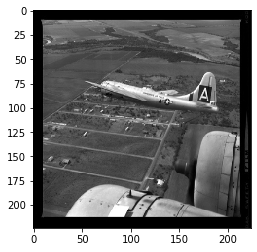

In [321]:
ind = 23
sample_im = images[ind] #read a sample image
plt.imshow(sample_im)
plt.show()

In [322]:
#Get the prediction for the selected image.

feature_maps = sess2.run([loaded_output], feed_dict={'inputs:0':np.reshape(sample_im, (-1,224,224,3)), 'dropout:0':1.0})

pred_conf, pred_bb = sess1.run([logits, anchor_conv_reshape],
                              feed_dict={X: feature_maps[0]})

pred_conf = an_bools*pred_conf #filter out the ignored anchors

In [323]:
#indexes of the pred array that holds 30 top confidence scores.
thresholded_indexes = np.reshape(np.reshape(pred_conf[0,:,0], (-1,1)).argsort(axis=0)[-40:], (-1))

In [324]:
filtered_predictions = []

#calculate the bounding box coordinates based on referenced anchors for each filtered predictions.

for index in thresholded_indexes:
    
    confidence = pred_conf[0,index,0]
    
    ref_anchor = anchors[index]
    
    #calculate the x,y,w,h of the predicted bounding box
    x = (pred_bb[0, index, 0]*ref_anchor[2]) + ref_anchor[0]
    y = (pred_bb[0, index, 1]*ref_anchor[3]) + ref_anchor[1]
    w = ref_anchor[2]*(math.e**pred_bb[0, index, 2])
    h = ref_anchor[3]*(math.e**pred_bb[0, index, 3])
    
    top_left_x = int(x - w/2)
    top_left_y = int(y - h/2)
    btm_rght_x = int(x + w/2)
    btm_rght_y = int(y + h/2)
    
    filtered_predictions.append([[top_left_x, top_left_y, btm_rght_x, btm_rght_y], [confidence]])


In [325]:
def find_highest_conf(predictions):
    
    '''
    Find the index of the array with the highest confidence given a list of predictions with confidences.
    '''
    
    temp_confidence = 0
    index_counter   = 0
    i = 0
    
    for _, conf in predictions:
        
        if conf[0] > temp_confidence:
            
            temp_confidence = conf[0] #update the temporary variable
            index_counter = i #update the variable with the index with the new highest confidence
        
        i+= 1
    
    return index_counter

In [326]:
def non_max_suppress(predictions):
    '''
    Non-Max Suppression process.
    1) Get the bounding box prediction with the highest confidence.
    2) Check the IoU of this selected bounding box with all the other remaining boxes iteratively.
    3) Whichever boxes that has more than a certain IoU will be removed from the list.
    4) Repeat the process until there are no more boxes left.
    '''
    predictions = predictions[:] #make a copy of the list so the original would not be affected.
    
    nms_iou_thresh = 0.6
    
    highest_conf_box = []
    
    while len(predictions) != 0 :
        
        highest_conf_index = find_highest_conf(predictions=predictions)
        
        #append the box with the highest confidence.
        highest_conf_box.append(predictions[highest_conf_index][0].copy())
        
        del predictions[highest_conf_index] #remove the selected box from the list.
        
        current_ref_box = highest_conf_box[-1] #pick the latest appended box.
        
        #get the area of the current selected box to calculate IoU.
        current_box_area = (current_ref_box[0] - current_ref_box[2] + 1)*\
                            (current_ref_box[1] - current_ref_box[3] + 1)
        
        index_to_keep = []
        i = 0
        
        for bb, _ in predictions:
            
            #calculate the IoU between the two boxes.
            iou = IoU_calculator(box1 = current_ref_box,
                                 box2 = bb,
                                 area1 = current_box_area,
                                 area2 = None)
            
            if iou > nms_iou_thresh : 
                
                #remove the bounding box from the predictions list.
                #i should not be incremented after the removal of the box since it shrinks the list.
                del predictions[i]
                continue
            
            i += 1
            
            
    return highest_conf_box

In [327]:
nms_result = non_max_suppress(filtered_predictions)

In [328]:
#draw the predictions after NMS process
img = sample_im.copy()
for bb in nms_result:
    
    img = cv2.rectangle(img, (bb[0], bb[1]), (bb[2], bb[3]), (255,0,0), 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


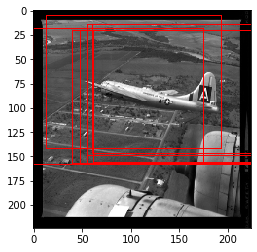

In [329]:
plt.imshow(img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


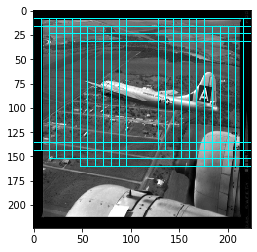

In [330]:
#The reference anchors (predicted)
img = sample_im.copy()

for i in thresholded_indexes:
    an = anchors[i]
    
    x = an[0]
    y = an[1]
    w = an[2]
    h = an[3]
    
    top_left_x = int(x - w/2)
    top_left_y = int(y - h/2)
    btm_rght_x = int(x + w/2)
    btm_rght_y = int(y + h/2)
    
    img = cv2.rectangle(img, (top_left_x, top_left_y), (btm_rght_x, btm_rght_y), (0,255,255), 1)

plt.imshow(img)
plt.show()

#### Ground Truth bounding box and the reference anchors

In [268]:
tmp = 0

listindex = []
j = []

for bb in batch_regression_array[ind]:
    
    if np.sum(bb) != 0:
        listindex.append(tmp)
        
    tmp += 1

In [269]:
img = sample_im.copy()

for every_index in listindex:
    
    pick_anchor = anchors[every_index]
    
    
    anchor_x1 = int(pick_anchor[0] - pick_anchor[2]/2)
    anchor_y1 = int(pick_anchor[1] - pick_anchor[3]/2)
    anchor_x2 = int(pick_anchor[0] + pick_anchor[2]/2)
    anchor_y2 = int(pick_anchor[1] + pick_anchor[3]/2)
     
    true_bb = batch_regression_array[ind][every_index]
    
    x = (true_bb[0]*pick_anchor[2]) + pick_anchor[0]
    y = (true_bb[1]*pick_anchor[3]) + pick_anchor[1]
    w = pick_anchor[2]*(pow(math.e,true_bb[2]))
    h = pick_anchor[3]*(pow(math.e,true_bb[3]))
    
    top_left_x = int(x - w/2)
    top_left_y = int(y - h/2)
    btm_rght_x = int(x + w/2)
    btm_rght_y = int(y + h/2)
    
    img = cv2.rectangle(img, (top_left_x, top_left_y), (btm_rght_x, btm_rght_y), (255,0,0), 2)
    img = cv2.rectangle(img, (anchor_x1, anchor_y1), (anchor_x2, anchor_y2), (0,255,0), 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


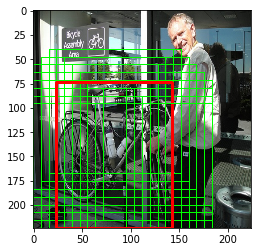

In [270]:
plt.imshow(img)
plt.show()
#Red box is the calculated regression from the ground-truth regression values
#Green boxes are the reference anchors (ground-truth) to the object.

In [274]:
gt = batch_gt_boxes[ind][0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


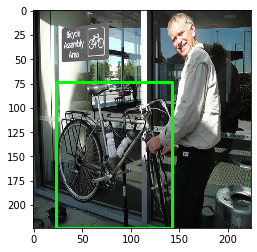

In [273]:
img = sample_im.copy()

img = cv2.rectangle(img, (int(gt[0]), int(gt[1])), (int(gt[2]), int(gt[3])), (0,255,0), 2)
plt.imshow(img)
plt.show()
#Ground truth bounding box from the xml file itself.

### Summary

The purpose of RPN is to propose regions to the next network, which the Faster-RCNN classification network. The predicted bounding boxes will further be refined and filtered. Though RPN can be used as a standalone network as a one-class detector, it is difficult to train the RPN network to produce accurate results.